# Detecting and analyzing news events

Damian Trilling and Marieke van Hoof


This Notebook contains the analysis of the similarity files created with the INCA-functions to calculate cosine and soft-cosine similarities.

In [2]:
import os
from glob import glob
import json
from tqdm import tqdm
import leidenalg
import igraph as ig
import networkx as nx
import infomap
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.externals import joblib
from utilities import most_distinguishing_words
from string import punctuation
punctuation = punctuation+"‘–"
from nltk import ngrams
import requests
stopword_list = requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-nl/master/stopwords-nl.txt").text.splitlines()
%matplotlib inline

## Load/specify datasets

We need to load three datasets:

1. Nodes and edges for the softcosine-dataset
2. As a baseline for comparisons: nodes and edges for the traditional cosine dataset
3. The articles themselves (titles, texts, ...) to join with the first two datasets

In [3]:
softcosinefiles = glob('../../data/intermediate/softcosine/*.net')
cosinefiles = glob('../../data/intermediate/cosine/*.net')

print('There are {} softcosine and {} cosine files.'.format(len(softcosinefiles), len(cosinefiles)))

There are 149 softcosine and 149 cosine files.


In [4]:
# There are essentially two ways of going about combining all our files
# Either we merge them first and create ONE graph that we partition later,
# or we partition each file's graph seperately.
# The theoretical implication is that in the first scenario, the three-day
# moving window can be stretched (as something on the last day of a window
# can also be similar to sth in the 'new' window), in the latter scenario,
# that's not possible. 
# Empirical tests show that this stretching can lead to a drift over time,
# with large partitions that extend to multiple events. 
# However, this problem only emerges when using an unsuitable clustering
# algorithm, in particular modularity (instead of surprise)

def merge_pajekfiles(files, outputfile):
    G = nx.Graph()
    for f in tqdm(files):
        H = nx.read_pajek(f)
        for node in H:         # remove all node properties, such as misleading/non-unique ids
            del H.node[node]['id']
            del H.node[node]['x']
            del H.node[node]['y']
            del H.node[node]['shape']
        G.update(H)
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    print('Removing self loops...')
    G.remove_edges_from(list(G.selfloop_edges()))
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    nx.write_pajek(G, outputfile)
    print('All written to {}'.format(outputfile))
    return G
Gnxsoft = merge_pajekfiles(softcosinefiles, '../../data/intermediate/softcosine_merged.net')
Gnxcos = merge_pajekfiles(cosinefiles, '../../data/intermediate/cosine_merged.net')
Gsoft = ig.read('../../data/intermediate/softcosine_merged.net', format='pajek')
Gcos = ig.read('../../data/intermediate/cosine_merged.net', format='pajek')


100%|██████████| 149/149 [00:46<00:00,  2.77it/s]


45608 nodes and 935592 edges
Removing self loops...
45608 nodes and 890597 edges


  1%|▏         | 2/149 [00:00<00:11, 12.91it/s]

All written to ../../data/intermediate/softcosine_merged.net


100%|██████████| 149/149 [00:09<00:00, 18.30it/s]


45213 nodes and 109336 edges
Removing self loops...
45213 nodes and 64341 edges
All written to ../../data/intermediate/cosine_merged.net


In [4]:
with open('../../data/raw-private/articles/articles_as_json-lines.json', mode='r') as f:
    articles = pd.DataFrame((json.loads(l) for l in f))
print(articles.keys())
print('{} articles in total'.format(len(articles)))

Index(['_id', 'byline', 'category', 'doctype', 'feedurl', 'images',
       'paywall_na', 'publication_date', 'softcosine_processed', 'teaser',
       'teaser_rss', 'text', 'title', 'title_rss', 'url'],
      dtype='object')
45609 articles in total


## Define functions
Here, we define functions to transform the files to a graph, partition the graph, analyze it, etc.

In [5]:
def partition_graph(G0, minedgeweight):
    '''takes an igraph, prunes it and particions it. returns a list of partitions '''
    G = G0.copy()
    G.es.select(weight_le=minedgeweight).delete()
    # part = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition)
    part = leidenalg.find_partition(G, leidenalg.SurpriseVertexPartition)
    # print(part.summary())
    partitions = []
    for subgraph in part.subgraphs():
         partitions.append([node['id'] for node in subgraph.vs])
    return partitions

In [6]:
def show_descriptives(results, filename=None):
    '''takes a list of lists (articles per event), plots a histogram and prints descriptives'''
    articles_per_event = [len(x) for x in results]
    single_article_events = sum([1 if e==1 else 0 for e in articles_per_event])
    multiple_article_events = len(articles_per_event) - single_article_events
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_event, bins = max(articles_per_event), log=True)
    if filename:
        plt.savefig(filename+'.png', dpi=400)
        plt.savefig(filename+'.eps')
    plt.show()
    print(pd.Series(articles_per_event).describe())
    print('\nThere are {} single-article events and {} multiple-article events.'.format(
        single_article_events, multiple_article_events))

In [7]:
def print_gridreport(gridresults):
    for r in gridresults:
        l = r['results']
        flattened = [item for sublist in l for item in sublist]

        print('Found {} articles, out of which {} are unique articles'.format(len(flattened), len(set(flattened))))
    print('(hint: if *not* all articles are unique, then articles are assigned to multiple events)')
    print('\n\n')

    for r in gridresults:
        print("*"*80)
        print('Similarity metric: {}\n Minimum edgeweight: {}\n'.format(r['similarity'], r['minedgeweight']))
        print("*"*80)
        show_descriptives(r['results'], filename = '../../report/figures/{}{}'.format(r['similarity'], 
                                                                                      str(r['minedgeweight']).replace('.','')))
        print('\n\n\n')

## Conduct clustering

We now conduct the clustering. We use a grid in which we vary the similarity calculation (cosine vs softcosine) and the minimum edgeweight threshold (.2, .3, .4, .5, .6)

In [8]:
grid = [('cos', Gcos, .2),
        ('cos', Gcos, .3),
        ('cos', Gcos, .4),
        ('cos', Gcos, .5),
        ('cos', Gcos, .6),
        ('softcos', Gsoft, .2),
        ('softcos', Gsoft, .3),
        ('softcos', Gsoft, .4),
        ('softcos', Gsoft, .5),
        ('softcos', Gsoft, .6)]

gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': partition_graph(G, minedgeweight)} 
              for similarity, G, minedgeweight in tqdm(grid)]



100%|██████████| 10/10 [01:17<00:00,  7.09s/it]


Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
(hint: if *not* all articles are unique, then articles are assigned to multiple events)



********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.2

********************************************************************************


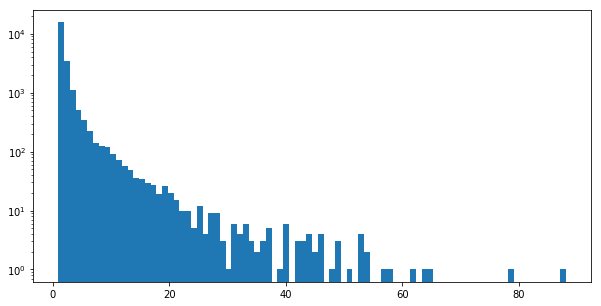

count    22312.000000
mean         2.026398
std          3.473195
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         88.000000
dtype: float64

There are 15630 single-article events and 6682 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.3

********************************************************************************


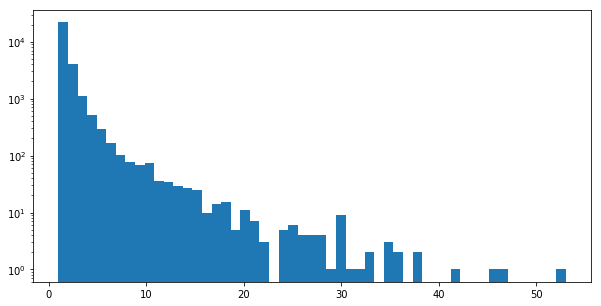

count    28635.000000
mean         1.578942
std          2.005513
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         53.000000
dtype: float64

There are 21856 single-article events and 6779 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.4

********************************************************************************


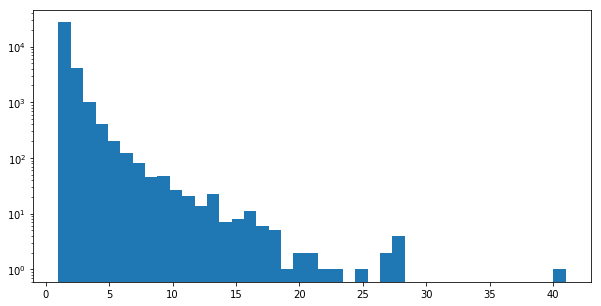

count    33378.000000
mean         1.354575
std          1.210611
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
dtype: float64

There are 27136 single-article events and 6242 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.5

********************************************************************************


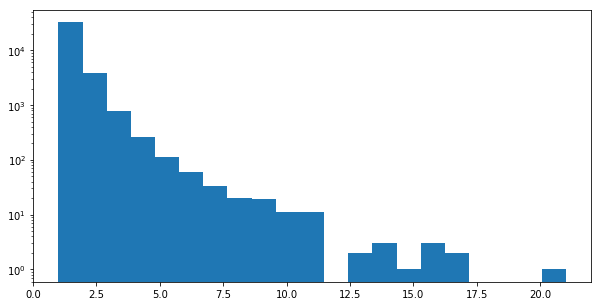

count    37397.000000
mean         1.209001
std          0.712653
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
dtype: float64

There are 32232 single-article events and 5165 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.6

********************************************************************************


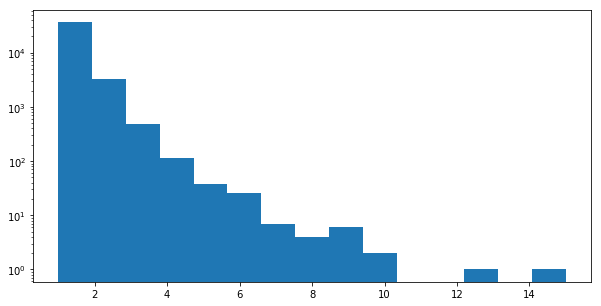

count    40247.000000
mean         1.123388
std          0.449985
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
dtype: float64

There are 36348 single-article events and 3899 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.2

********************************************************************************


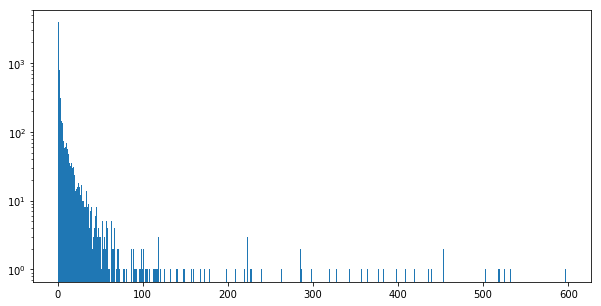

count    6401.000000
mean        7.125137
std        30.599078
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       597.000000
dtype: float64

There are 3918 single-article events and 2483 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.3

********************************************************************************


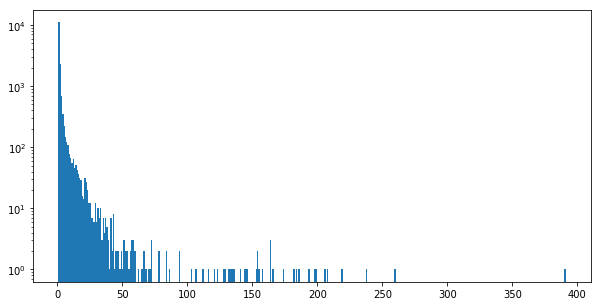

count    15789.000000
mean         2.888593
std         10.121378
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        391.000000
dtype: float64

There are 11037 single-article events and 4752 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.4

********************************************************************************


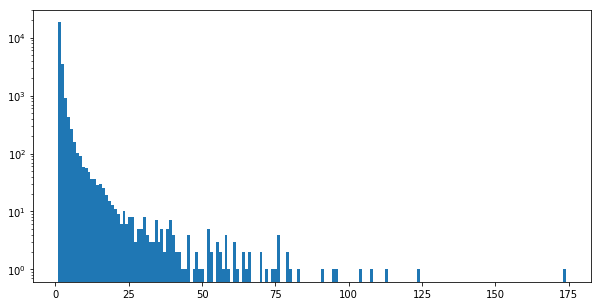

count    24295.000000
mean         1.877259
std          4.319026
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        174.000000
dtype: float64

There are 18335 single-article events and 5960 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.5

********************************************************************************


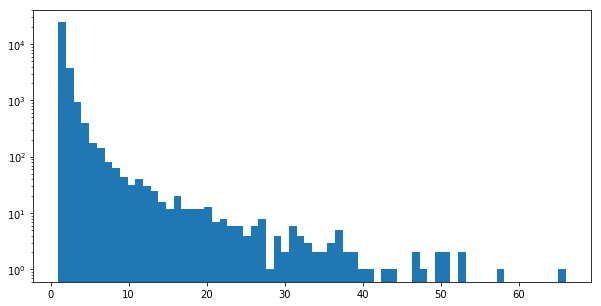

count    30271.000000
mean         1.506657
std          2.262406
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         66.000000
dtype: float64

There are 24325 single-article events and 5946 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.6

********************************************************************************


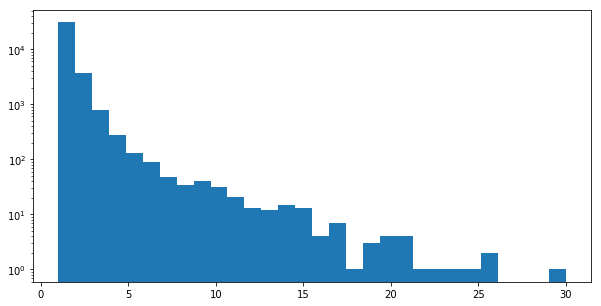

count    35958.000000
mean         1.268369
std          1.070040
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         30.000000
dtype: float64

There are 30700 single-article events and 5258 multiple-article events.






In [9]:
print_gridreport(gridresults)

## Evaluation of the results

check how much sense it makes etc

In [10]:
def merge_results_with_articles(results):
    results_merged = [[articles.query('_id=="{}"'.format(art)) for art in event] for event in results]
    df = pd.DataFrame(results_merged)
    return df

def _getfield(x, field):
    try:
        return x[field].to_list()[0]
    except:
        return None
def reduce_to_field(merged_df, field):
    return merged_df.applymap(lambda x: _getfield(x, field))

In [11]:
df_cos04 = merge_results_with_articles(gridresults[2]['results'])
df_cos05 = merge_results_with_articles(gridresults[3]['results'])
df_cos06 = merge_results_with_articles(gridresults[4]['results'])
df_softcos04 = merge_results_with_articles(gridresults[7]['results'])
df_softcos05 = merge_results_with_articles(gridresults[8]['results'])
df_softcos06 = merge_results_with_articles(gridresults[9]['results'])

### Manual evaluation of method
To evaluate the cosine and softcosine simiarlity methods on precision, we manually inspect a random sample of 100 multiple-article news events for minedgeweight=0.4, 0.5 and 0.6. Precision is defined as the number of articles  in the cluster that relate to the news event relative to the total number of articles in the cluster. The files can be found in ../../data/evaluation.

#### Create random samples

In [12]:
outdir = '../../data/evaluation'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [13]:
df_list = [df_cos04, df_cos05, df_cos06, df_softcos04, df_softcos05, df_softcos06]
names = ['cos04', 'cos05', 'cos06', 'softcos04', 'softcos05', 'softcos06']

In [14]:
i = 101
for name, data in zip(names, df_list):
    df = reduce_to_field(data, 'title')
    n_articles = df.count(axis=1)
    df = df.join(n_articles.rename('n_articles'))
    df = df.loc[df.n_articles > 1] # reducde to multi-article news events
    df.replace(',' '', inplace=True)
    df = df.sample(n=100, random_state=i)
    filename = '{name}_EMPTY.csv'.format(name=name)
    df.to_csv(os.path.join(outdir, filename), sep=',')
    print('Random sample for', name, 'with random_state =', i, 'saved as ../../data/evaluation/{name}_EMPTY.csv'.format(name=name))
    i += 1

Random sample for cos04 with random_state = 101 saved as ../../data/evaluation/cos04_EMPTY.csv
Random sample for cos05 with random_state = 102 saved as ../../data/evaluation/cos05_EMPTY.csv
Random sample for cos06 with random_state = 103 saved as ../../data/evaluation/cos06_EMPTY.csv
Random sample for softcos04 with random_state = 104 saved as ../../data/evaluation/softcos04_EMPTY.csv
Random sample for softcos05 with random_state = 105 saved as ../../data/evaluation/softcos05_EMPTY.csv
Random sample for softcos06 with random_state = 106 saved as ../../data/evaluation/softcos06_EMPTY.csv


#### Calculate precision

Precision is presented in three ways:
 - __Prec. 1:__ Percentage of news events that are entirely correct.
 - __Prec. 2:__ Percentage of news articles that relate to the news events correctly.
 - __TP/max. TP:__ True Positives out of the maximum True Postives.

In [15]:
eval_list = []
for name in names:
    eval_list.append(pd.read_csv('../../data/evaluation/{}_DONE.csv'.format(name), sep=';'))

In [16]:
def calculate_precision(df):
    df['precision'] = np.where(df.n_articles == df.n_correct, 1, 0)
    score_opt1 = (df['precision'].value_counts()[1] / len(df)) * 100
    df['proportion_correct'] = (df.n_correct / df.n_articles) * 100
    score_opt2 = df.proportion_correct.mean()
    score_opt3 = sum(df.n_correct)
    total_articles = sum(df.n_articles)
    print('Perc. 1:', score_opt1, '\nPrec. 2:', score_opt2, '\nTP/max. TP:', score_opt3, '/', total_articles)

In [17]:
precision_df = pd.DataFrame()
for name, df in zip(names, eval_list):
    print('Results for...', name)
    calculate_precision(df)

Results for... cos04
Perc. 1: 74.0 
Prec. 2: 88.51709401709401 
TP/max. TP: 223 / 268
Results for... cos05
Perc. 1: 78.0 
Prec. 2: 89.01666666666667 
TP/max. TP: 217 / 253
Results for... cos06
Perc. 1: 89.0 
Prec. 2: 94.38690476190476 
TP/max. TP: 204 / 225
Results for... softcos04
Perc. 1: 56.00000000000001 
Prec. 2: 76.2042970917971 
TP/max. TP: 234 / 521
Results for... softcos05
Perc. 1: 65.0 
Prec. 2: 81.7704939668175 
TP/max. TP: 236 / 379
Results for... softcos06
Perc. 1: 75.0 
Prec. 2: 86.91932234432235 
TP/max. TP: 222 / 289


### RQ1

In [18]:
def get_venn_from_outlets(outlet_df, filename=None):
    outlets_per_event = outlet_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)
    dichotomized = outlets_per_event.applymap(lambda x: x > 0)
    events_ad = set(dichotomized[dichotomized['ad (www)']==True].index)
    events_vk = set(dichotomized[dichotomized['volkskrant (www)']==True].index)
    events_nu = set(dichotomized[dichotomized['nu']==True].index)
    fig = plt.figure(figsize=(10,10))
    venn3([events_ad, events_vk, events_nu], set_labels = ['AD', 'Volkskrant', 'nu'])
    if filename:
        plt.savefig(filename+'.png', dpi=400)
        plt.savefig(filename+'.eps')
    plt.show()

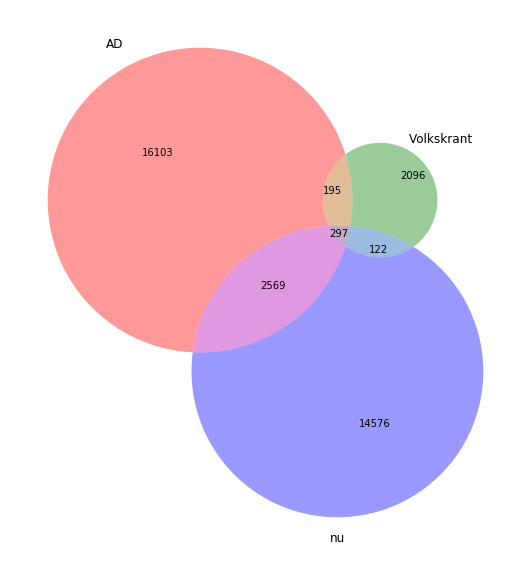

In [19]:
df_softcos06_outlet = reduce_to_field(df_softcos06, 'doctype')
get_venn_from_outlets(df_softcos06_outlet, '../../report/figures/vennsoft06')

### RQ2

To compare the content of fully covered news events with AD-only, Volkskrant-only and nu.nl-only news events, we apply an automated method that classifies Dutch news items into four news categories: Politics, Business, Entertainment and Other ([Vermeer, 2018](https://figshare.com/articles/A_supervised_machine_learning_method_to_classify_Dutch-language_news_items/7314896/1)).

In [20]:
def get_fully_covered_events(outlet_df):
    outlets_per_event = outlet_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)
    dichotomized = outlets_per_event.applymap(lambda x: x > 0)
    
    events_fullycovered = set(dichotomized[dichotomized.sum(axis=1)==3].index)
    ad_only = set(dichotomized[(dichotomized['ad (www)'] == 1) & (dichotomized['nu'] == 0) & (dichotomized['volkskrant (www)'] == 0)].index)
    vk_only = set(dichotomized[(dichotomized['ad (www)'] == 0) & (dichotomized['nu'] == 0) & (dichotomized['volkskrant (www)'] == 1)].index)
    nu_only = set(dichotomized[(dichotomized['ad (www)'] == 0) & (dichotomized['nu'] == 1) & (dichotomized['volkskrant (www)'] == 0)].index)
    
    groups = (events_fullycovered, ad_only, vk_only, nu_only)
    
    return groups

def get_topics(text_df, path_to_model):
    clf = joblib.load(path_to_model)
    i=0
    all_text = text_df.values.tolist()
    no_none = []
    for l in all_text:
        for text in l:
            if text == None:
                i+=1
            elif text != None:
                # make lowercase and remove punctuation and stopwords.
                text = text.lower().translate(str.maketrans('', '', punctuation)).split()
                filtered_text = []
                for word in text:
                    if word not in stopword_list:
                        filtered_text.append(word)
                no_none.append(" ".join(filtered_text))
    
    topic = clf.predict([e for e in no_none])
    unique, counts = np.unique(topic, return_counts=True)
    result = dict(zip(unique, counts/len(topic)*100))
    
    return result

def topic_graph(topics):
    labels = ['Fully covered', 'AD only', 'VK only', 'nu.nl only']
    barWidth = 0.23

    plt.figure(figsize=(10,5))

    r1 = np.arange(len(topics['Business']))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    plt.bar(r1, topics['Business'], width=barWidth, label='Business')
    plt.bar(r2, topics['Entertainment'], width=barWidth, label='Entertainment')
    plt.bar(r3, topics['Politics'], width=barWidth, label='Politics')
    plt.bar(r4, topics['Other'], width=barWidth, label='Other')

    plt.xlabel('')
    plt.xticks([r + barWidth for r in range(len(topic_fully))], labels)

    plt.legend()
    filename = '../../report/figures/classification'
    plt.savefig(filename+'.png', dpi=400)
    plt.savefig(filename+'.eps')
    plt.show()

In [21]:
# Download classifier by Vermeer (2018) if we don't have it yet

PATH_TO_MODEL = '../lib/PassiveAggressive_text_Dutch_news.pkl'

if not os.path.exists(PATH_TO_MODEL):
    r = requests.get('https://ndownloader.figshare.com/files/13514468', allow_redirects=True)
    with open(PATH_TO_MODEL, mode = 'wb') as f:
        f.write(r.content)
    print('Downloaded classifier with status code {} and saved as {}'.format(r.status_code, PATH_TO_MODEL))

In [22]:
df_softcos06_outlet = reduce_to_field(df_softcos06, 'doctype')
groups = get_fully_covered_events(df_softcos06_outlet)

In [23]:
df_softcos06_text = reduce_to_field(df_softcos06, 'text')

In [24]:
fully_text = df_softcos06_text.iloc[list(groups[0])]
ad_text = df_softcos06_text.iloc[list(groups[1])]
vk_text = df_softcos06_text.iloc[list(groups[2])]
nu_text = df_softcos06_text.iloc[list(groups[3])]

In [25]:
topic_fully = get_topics(fully_text, PATH_TO_MODEL)
topic_ad = get_topics(ad_text, PATH_TO_MODEL)
topic_vk = get_topics(vk_text, PATH_TO_MODEL)
topic_nu = get_topics(nu_text, PATH_TO_MODEL)

In [26]:
topics = pd.DataFrame([topic_fully, topic_ad, topic_vk, topic_nu])
topics

,Business,Entertainment,N/A,Other,Politics
0,18.746503,41.074426,NaN,9.121433,31.057639
1,12.310848,78.920237,0.016629,2.361288,6.390998
2,22.191142,37.435897,0.046620,3.496503,36.829837
3,18.516104,71.560829,0.032599,3.279437,6.611031


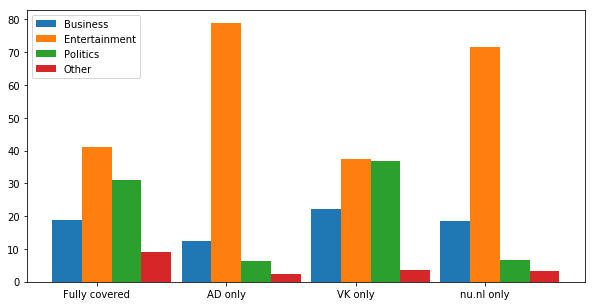

In [27]:
topic_graph(topics=topics)

In [28]:
def column_to_words(df, bigrams = True):
    '''we are only considering the first article; we only want one per event b/c we 
    are interested in the events not the articles'''
    longstring = df[0].str.cat()
    longstring = longstring.translate(str.maketrans('', '', punctuation))
    tokens = [w.lower() for w in longstring.split()]
    filtered_tokens=[]
    for word in tokens:
        if word not in stopword_list:
            filtered_tokens.append(word)
    if bigrams:
        filtered_tokens.extend(["_".join(tup).lower() for tup in ngrams(longstring.split(),2)])
    return filtered_tokens

### ad vs fully covered
it's sports

In [29]:
md_ad = most_distinguishing_words(column_to_words(ad_text), column_to_words(fully_text), top = 20)
md_ad

,loglikelihood,word,observed corpus 1,expected corpus 1,observed corpus 2,expected corpus 2
0,82.285596,seizoen,2041,1983.8992086844405,8,65.10079131555955
1,67.078467,auto,2038,1984.867436702344,12,65.13256329765596
2,59.854001,punten,1423,1382.6296095663158,5,45.37039043368425
3,56.596026,finale,1015,983.7196661900398,1,32.28033380996022
4,40.754149,wedstrijd,1345,1310.9807362414506,9,43.01926375854935
5,39.283825,wk,737,714.5522772128438,1,23.447722787156145
6,37.836459,ploeg,962,935.3082652948607,4,30.691734705139343
7,37.747194,nummer,1098,1068.923731765555,6,35.07626823444497
8,37.297483,club,1451,1416.517590192941,12,46.482409807058865
9,37.120930,dit_seizoen,702,680.6642965862185,1,22.33570341378153


In [30]:
with open('../../report/table_appendix_loglikelihood_ad.tex', mode='w') as f:
    f.write(md_ad.to_latex())

### nu vs fully covered
it's sports and entertainment and crime

In [31]:
md_nu = most_distinguishing_words(column_to_words(nu_text), column_to_words(fully_text), top = 20)
md_nu

,loglikelihood,word,observed corpus 1,expected corpus 1,observed corpus 2,expected corpus 2
0,110.350688,uur,4751,4635.4757273190135,54,169.5242726809863
1,81.167876,auto,2068,2006.6159235845055,12,73.38407641549458
2,78.927624,seizoen,1781,1725.8826381214808,8,63.11736187851914
3,75.270898,the,2466,2399.2566355551276,21,87.74336444487261
4,75.187777,film,1516,1467.3378941211695,5,53.66210587883042
5,69.090713,politie,5613,5508.546597917079,97,201.45340208292023
6,63.862579,uur_op,889,857.6353634935699,0,31.364636506430138
7,63.122136,nunl,1398,1354.4657484195411,6,49.53425158045884
8,54.317433,aangehouden,1321,1281.1470896731842,7,46.852910326815774
9,49.998149,festival,696,671.4445590455845,0,24.555440954415495


In [32]:
with open('../../report/table_appendix_loglikelihood_nu.tex', mode='w') as f:
    f.write(md_nu.to_latex())

### vk vs fully covered
it's politics!

In [33]:
md_vk = most_distinguishing_words(column_to_words(vk_text), column_to_words(fully_text), top = 20)
md_vk

,loglikelihood,word,observed corpus 1,expected corpus 1,observed corpus 2,expected corpus 2
0,25.869075,zegt,3831,3750.5041023396448,216,296.49589766035507
1,23.060012,auto’s,200,186.27411034600163,1,14.72588965399836
2,22.673511,hesjes,149,138.0837932415634,0,10.916206758436596
3,22.217285,hoogleraar,286,268.7536915439825,4,21.246308456017534
4,21.656240,politieke,905,871.1326553494604,35,68.8673446505396
5,21.640624,huizen,190,177.0067416720712,1,13.99325832792879
6,21.303970,gele_hesjes,140,129.74316143502602,0,10.256838564973982
7,20.443092,gele,215,201.10190022429032,2,15.898099775709673
8,19.240663,nieuwsbrief,173,161.25221492638948,1,12.74778507361052
9,18.177646,zorg,302,285.43495515705723,6,22.56504484294276


In [34]:
with open('../../report/table_appendix_loglikelihood_vk.tex', mode='w') as f:
    f.write(md_vk.to_latex())

# Compare with infomap

infomap was used by Nicholls2018. It does not require a threshold (they say)

In [7]:
def findCommunities(Gin, minedgeweight=None):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    
    G = Gin.copy()
    
    if minedgeweight:
        insignificant_edges = ([(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < minedgeweight])
        G.remove_edges_from(insignificant_edges)

    infomapWrapper = infomap.Infomap("--two-level --silent")  # even testen zonder two-level
    # infomapWrapper = infomap.Infomap(" --silent")
    
    network = infomapWrapper.network()

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges(data=True):
        network.addLink(e[0],e[1],e[2]['weight'])

    print("Find communities with Infomap...")
    infomapWrapper.run();

    #tree = network.tree

    # print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

    print("Found {} modules with codelength: {}".format(infomapWrapper.numTopModules(), infomapWrapper.codelength()))

    print("Result")
    print("\n#node module")
 
    communities = {}
    for node in infomapWrapper.iterTree():
        if node.isLeaf():
            print("{} {}".format(node.physicalId, node.moduleIndex()))
    
        communities[node.physicalId] = node.moduleIndex()

    nx.set_node_attributes(G, name='community', values=communities)
    return G

In [8]:
Gnxint = nx.convert_node_labels_to_integers(Gnxcos)
H = findCommunities(Gnxint)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 6628 modules with codelength: 3.982447307242272
Result

#node module
0 0
1 0
2 0
27 0
28 0
99 0
100 0
108 0
109 0
355 0
383 0
430 0
431 0
432 0
433 0
444 0
454 0
466 0
483 0
484 0
486 0
494 0
522 0
551 0
6234 0
6235 0
6236 0
6237 0
6251 0
6252 0
6253 0
6310 0
6311 0
6315 0
6316 0
6317 0
6318 0
6319 0
6320 0
12080 0
12360 0
12361 0
12404 0
12405 0
12406 0
12407 0
12431 0
12439 0
12440 0
12442 0
17553 0
17793 0
38813 0
38859 0
38919 0
41818 0
4 1
5 1
422 1
6005 1
37047 1
37052 1
6 2
7 2
8 2
9 3
10 3
31 3
32 3
33 3
34 3
35 3
36 3
37 3
95 3
12 4
13 4
14 4
15 4
417 4
37107 4
37108 4
18 5
19 5
157 5
158 5
159 5
418 5
419 5
420 5
485 5
6274 5
6275 5
17760 5
23917 5
37068 5
39016 5
39020 5
39021 5
20 6
21 6
55 6
56 6
57 6
58 6
289 6
423 6
22 7
23 7
24 7
25 8
26 8
30 9
37097 9
37098 9
38 10
39 10
40 10
233 10
447 10
41 11
42 11
43 11
421 11
44 12
45 12
487 12
488 12
489 12
490 12
538 12
6230 12
6231 12
6327

2196 472
2381 472
2382 472
2383 472
2200 473
18970 473
2201 474
2202 474
2203 474
2204 474
2385 474
18914 474
18915 474
19018 474
2211 475
19821 475
2217 476
2218 476
2222 477
2223 477
2227 478
2387 478
2230 479
19743 479
19744 479
2231 480
2388 480
2232 481
2233 481
2234 481
2236 482
2389 482
32769 482
2242 483
2390 483
32817 483
2252 484
19754 484
19755 484
19756 484
2253 485
19917 485
2256 486
2395 486
2260 487
18839 487
18840 487
18841 487
18894 487
2267 488
2268 488
2271 489
18999 489
19887 489
2279 490
2400 490
19911 490
2280 491
18994 491
19908 491
2289 492
19042 492
2401 493
2402 493
2403 493
2404 493
2405 493
2406 493
2407 493
2551 493
2702 493
2703 493
2704 493
2705 493
2706 493
2707 493
2708 493
2709 493
2710 493
2711 493
2712 493
2713 493
2714 493
2715 493
2716 493
2717 493
2757 493
2764 493
2817 493
2818 493
14453 493
14687 493
14688 493
14689 493
14690 493
14691 493
14789 493
14995 493
14996 493
32596 493
35644 493
35645 493
2409 494
2410 494
44986 494
2411 495
2412 495
2

4877 836
4878 836
4879 836
4880 836
5087 836
5135 836
5136 836
17076 836
17117 836
28526 836
4025 837
4197 837
4805 837
4830 837
4831 837
5064 837
5071 837
5148 837
5164 837
9473 837
17379 837
4026 838
4027 838
4107 838
4249 838
4030 839
28627 839
4031 840
17239 840
4037 841
4038 841
4039 841
4041 842
4042 842
4250 842
4251 842
4044 843
4045 843
4252 843
4046 844
4047 844
4051 845
4052 845
4253 845
4254 845
4053 846
4054 846
4055 846
4058 847
4256 847
4059 848
4257 848
17220 848
4063 849
4064 849
4067 850
4068 850
4199 850
4258 850
4259 850
5192 850
9217 850
9218 850
17253 850
17254 850
17255 850
4069 851
4200 851
4072 852
4073 852
4076 852
4201 852
28527 852
28528 852
4074 853
4075 853
4203 853
4260 853
4261 853
17100 853
17101 853
17102 853
17178 853
17179 853
4081 854
4202 854
4087 855
4088 855
4090 856
4204 856
4262 856
9200 856
9201 856
9480 856
9534 856
17202 856
27408 856
28518 856
4091 857
4092 857
4223 857
4279 857
9448 857
17369 857
4093 858
4094 858
4095 859
17245 859
17246 

6968 1399
7160 1399
26062 1399
6977 1400
23369 1400
6978 1401
7229 1401
6983 1402
7232 1402
23418 1402
6984 1403
7233 1403
6985 1404
7162 1404
7163 1404
7164 1404
7165 1404
26107 1404
26281 1404
26282 1404
6987 1405
6988 1405
7001 1406
7171 1406
7003 1407
7004 1407
7005 1407
23440 1407
23454 1407
26105 1407
7006 1408
7238 1408
7011 1409
7012 1409
7187 1409
7013 1410
23411 1410
7016 1411
7017 1411
7018 1412
7241 1412
7019 1413
7020 1413
7174 1413
7175 1413
7176 1413
7188 1413
7242 1413
7243 1413
7026 1414
7027 1414
7031 1415
7178 1415
7179 1415
7244 1415
7035 1416
7251 1416
43004 1416
7038 1417
7039 1417
7253 1417
42984 1417
42985 1417
42986 1417
7042 1418
7255 1418
7045 1419
18733 1419
18763 1419
23205 1419
23274 1419
23305 1419
23307 1419
23308 1419
23382 1419
23449 1419
23450 1419
26339 1419
26340 1419
28206 1419
28207 1419
28324 1419
43133 1419
7047 1420
18754 1420
7049 1421
7256 1421
28214 1421
7052 1422
7053 1422
7057 1423
7261 1423
23243 1423
43107 1423
7058 1424
7260 1424
26234 

20364 1920
25067 1920
25228 1920
25229 1920
10045 1921
10046 1921
10047 1922
20321 1922
20322 1922
10048 1923
10049 1923
10050 1924
10051 1924
10052 1925
20345 1925
10054 1926
10055 1926
10056 1927
10057 1927
10058 1927
10059 1927
10138 1927
10251 1927
10267 1927
10416 1927
10417 1927
10448 1927
20373 1927
25010 1927
10061 1928
10418 1928
25163 1928
25164 1928
25165 1928
34801 1928
10063 1929
10064 1929
10163 1929
10164 1929
10165 1929
10215 1929
10440 1929
10441 1929
10455 1929
10483 1929
20354 1929
25253 1929
10065 1930
10122 1930
10348 1930
10393 1930
10419 1930
10420 1930
10421 1930
10422 1930
25140 1930
25155 1930
10066 1931
10067 1931
10068 1931
10069 1931
10070 1931
10071 1931
10073 1932
10074 1932
10075 1932
10076 1932
10077 1932
10078 1932
10079 1932
10349 1932
10371 1932
10423 1932
10424 1932
10425 1932
10433 1932
25127 1932
25170 1932
10080 1933
10081 1933
10082 1933
10083 1933
10350 1933
10351 1933
10426 1933
20284 1933
20285 1933
20286 1933
20287 1933
10084 1934
10352 1934

12523 2379
12639 2379
30115 2379
30116 2379
30117 2379
30118 2379
30138 2379
30163 2379
30164 2379
12474 2380
12475 2380
12476 2380
12478 2381
12551 2381
12604 2381
30068 2381
30069 2381
30070 2381
30071 2381
30316 2381
39051 2381
12479 2382
30261 2382
12481 2383
12482 2383
30107 2383
30108 2383
30110 2383
12484 2384
12485 2384
12486 2384
12487 2384
12647 2384
12670 2384
12671 2384
12672 2384
12673 2384
12674 2384
12675 2384
12676 2384
12781 2384
13015 2384
13046 2384
13076 2384
13090 2384
14399 2384
14402 2384
14672 2384
14760 2384
14761 2384
15158 2384
30256 2384
31145 2384
31268 2384
31269 2384
31294 2384
31295 2384
31392 2384
12489 2385
12490 2385
12491 2386
12492 2386
12494 2387
12495 2387
12496 2388
30332 2388
43551 2388
12497 2389
12498 2389
14878 2389
14879 2389
15104 2389
15145 2389
15146 2389
39087 2389
39112 2389
12500 2390
12501 2390
12502 2390
12563 2390
12564 2390
12503 2391
12504 2391
12505 2392
12506 2392
12507 2392
30111 2392
30264 2392
30265 2392
39132 2392
39133 2392

28869 2938
29079 2938
15646 2939
15647 2939
15650 2940
15651 2940
15874 2940
25465 2940
15657 2941
15658 2941
15660 2942
15661 2942
15666 2943
15881 2943
15667 2944
15668 2944
15672 2945
15882 2945
15675 2946
15676 2946
15677 2946
15678 2946
15683 2947
15886 2947
15887 2947
15975 2947
28963 2947
15687 2948
25429 2948
15689 2949
15888 2949
28732 2949
28733 2949
15697 2950
15698 2950
16009 2950
15699 2951
15774 2951
15775 2951
15954 2951
15979 2951
15994 2951
28725 2951
36393 2951
36938 2951
15705 2952
15706 2952
25632 2952
15708 2953
22088 2953
22089 2953
22090 2953
22883 2953
23141 2953
24471 2953
24756 2953
24762 2953
25571 2953
25615 2953
34242 2953
36144 2953
44106 2953
15709 2954
15916 2954
29039 2954
15710 2955
15711 2955
15718 2956
15919 2956
15719 2957
15720 2957
15721 2958
15722 2958
15920 2958
15723 2959
15724 2959
15725 2959
15726 2959
15733 2960
15734 2960
15923 2960
15924 2960
25672 2960
28770 2960
28817 2960
28818 2960
29006 2960
29040 2960
15738 2961
15739 2961
15926 2961

22536 3888
22540 3889
22541 3889
22542 3889
22660 3889
22661 3889
44233 3889
44234 3889
44257 3889
44258 3889
22543 3890
22544 3890
22545 3891
22546 3891
22547 3891
22589 3891
22548 3892
22549 3892
22550 3892
22552 3893
22553 3893
22554 3894
22555 3894
22556 3895
22557 3895
22560 3896
22561 3896
22582 3897
22583 3897
22584 3898
22585 3898
22591 3899
22592 3899
22593 3900
22594 3900
22595 3900
22611 3901
35952 3901
35953 3901
36036 3901
22629 3902
22630 3902
22645 3903
22646 3903
22650 3904
22651 3904
22657 3905
22658 3905
22665 3906
22666 3906
22690 3907
44199 3907
44200 3907
44201 3907
44202 3907
44203 3907
44204 3907
22691 3908
44241 3908
22696 3909
22697 3909
22705 3910
22706 3910
22711 3911
22712 3911
22716 3912
44353 3912
22717 3913
22718 3913
22724 3914
44284 3914
22728 3915
44172 3915
44173 3915
22741 3916
44209 3916
22767 3917
22768 3917
24623 3917
24772 3917
22788 3918
22789 3918
22790 3919
22791 3919
22867 3919
22868 3919
22885 3919
22795 3920
22796 3920
22800 3921
22801 3921

31071 4987
32609 4987
32610 4987
32611 4987
31072 4988
31073 4988
31074 4988
31075 4988
31078 4989
31079 4989
31080 4989
31081 4990
31082 4990
31083 4990
31085 4991
31086 4991
31089 4992
31090 4992
31091 4993
31092 4993
31110 4994
31111 4994
31117 4994
31118 4995
31119 4995
31121 4996
31122 4996
32664 4996
31125 4997
31126 4997
31127 4998
31128 4998
31129 4999
31130 4999
31131 4999
31133 5000
31134 5000
31147 5001
31148 5001
31149 5001
31150 5001
31151 5001
31161 5002
31162 5002
31163 5003
32570 5003
31175 5004
31176 5004
31177 5005
31178 5005
31180 5006
31181 5006
32452 5006
32568 5006
32655 5006
31199 5007
31200 5007
31201 5008
32506 5008
31205 5009
31206 5009
31220 5010
31221 5010
31247 5011
31248 5011
31260 5012
32509 5012
31274 5013
31275 5013
32493 5013
32494 5013
31276 5014
31277 5014
31278 5014
31279 5015
31280 5015
31287 5016
31288 5016
31296 5017
31297 5017
31300 5018
31301 5018
31302 5018
31305 5019
31306 5019
31307 5019
31320 5020
31321 5020
31322 5020
31326 5021
31327 5021

42292 6322
42293 6322
42304 6323
42305 6323
42308 6324
42309 6324
42310 6324
42334 6324
42321 6325
42322 6325
42325 6326
42326 6326
42327 6326
42330 6327
42331 6327
42336 6328
42337 6328
42339 6329
42340 6329
42354 6330
42355 6330
42372 6331
42373 6331
42374 6332
42375 6332
42381 6333
42382 6333
42383 6334
42384 6334
42388 6335
42389 6335
42390 6335
42420 6336
42421 6336
42449 6337
42450 6337
42453 6338
42454 6338
42476 6339
42477 6339
42482 6340
42483 6340
42504 6341
42505 6341
42511 6342
42512 6342
42513 6342
42514 6342
42516 6343
42517 6343
42518 6344
42519 6344
42528 6345
42529 6345
42530 6346
42531 6346
42532 6347
42533 6347
42537 6348
42538 6348
42539 6348
42549 6349
42550 6349
42553 6350
42554 6350
42555 6350
42558 6351
42559 6351
42570 6352
42571 6352
42573 6353
42574 6353
42575 6354
42576 6354
42579 6355
42580 6355
42581 6356
42582 6356
42593 6357
42594 6357
42596 6358
42597 6358
42604 6359
42605 6359
42625 6360
42626 6360
42641 6361
42642 6361
42652 6362
42653 6362
42671 6363

In [9]:
Gnxsoftint = nx.convert_node_labels_to_integers(Gnxsoft)
Hsoft = findCommunities(Gnxsoftint)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 1805 modules with codelength: 10.056765439670455
Result

#node module
0 0
1 0
2 0
3 0
6 0
8 0
10 0
11 0
12 0
15 0
16 0
18 0
20 0
22 0
23 0
29 0
37 0
40 0
110 0
111 0
113 0
121 0
155 0
156 0
157 0
159 0
161 0
162 0
163 0
164 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
178 0
180 0
186 0
193 0
194 0
196 0
197 0
212 0
213 0
231 0
232 0
242 0
244 0
266 0
291 0
310 0
332 0
333 0
334 0
343 0
348 0
349 0
350 0
352 0
366 0
5991 0
6003 0
6020 0
6029 0
6030 0
6040 0
6089 0
6103 0
6105 0
6106 0
6143 0
6146 0
6150 0
6181 0
6183 0
6231 0
6250 0
6272 0
6273 0
6274 0
6280 0
6281 0
6282 0
6285 0
6286 0
6288 0
6293 0
6314 0
6315 0
6316 0
6317 0
6318 0
6322 0
6346 0
6350 0
6354 0
6356 0
6359 0
6361 0
6387 0
6397 0
6398 0
6400 0
6401 0
6402 0
6418 0
6419 0
6432 0
6448 0
6450 0
6482 0
6483 0
6484 0
6508 0
6530 0
13725 0
13726 0
13727 0
13729 0
13731 0
13732 0
13733 0
13734 0
13738 0
13759 0
13760 0
13761 0


21496 52
21497 52
21498 52
21499 52
21504 52
21509 52
21510 52
21512 52
21513 52
21514 52
21515 52
21516 52
21517 52
21518 52
21519 52
21520 52
21521 52
21522 52
21523 52
21524 52
21525 52
21526 52
21527 52
21528 52
21529 52
21530 52
21531 52
21532 52
21533 52
21534 52
21535 52
21536 52
21539 52
21540 52
21541 52
21542 52
21543 52
21544 52
21548 52
21549 52
21551 52
21553 52
21554 52
21558 52
21559 52
21560 52
21561 52
21562 52
21563 52
21564 52
21565 52
21566 52
21567 52
21568 52
21569 52
21570 52
21571 52
21573 52
21577 52
21594 52
21595 52
21599 52
21600 52
21602 52
21603 52
21604 52
21626 52
21627 52
21638 52
21639 52
21645 52
21646 52
21647 52
21648 52
21649 52
21659 52
21665 52
21666 52
21667 52
21668 52
21669 52
21670 52
21675 52
21690 52
21692 52
21693 52
21694 52
21695 52
21696 52
21703 52
21705 52
21715 52
21723 52
21724 52
21736 52
21738 52
21750 52
24796 52
24797 52
34508 52
34552 52
39474 52
39478 52
39484 52
39486 52
39487 52
39493 52
39494 52
39497 52
39504 52
39524 52
3

31833 109
31835 109
31836 109
31837 109
31838 109
31839 109
31840 109
31841 109
31842 109
31844 109
31845 109
31846 109
31847 109
31848 109
31849 109
31850 109
31851 109
31852 109
31853 109
31854 109
31856 109
31861 109
31862 109
31863 109
31864 109
31867 109
31868 109
31869 109
31870 109
31872 109
31874 109
31886 109
31904 109
31910 109
31911 109
31912 109
31913 109
31914 109
31915 109
31916 109
31917 109
31918 109
31919 109
31922 109
31923 109
31925 109
31927 109
31930 109
31931 109
31932 109
31933 109
31934 109
31941 109
31942 109
31943 109
31944 109
31945 109
31946 109
31947 109
31948 109
31949 109
31950 109
31951 109
31952 109
31954 109
31957 109
31958 109
31963 109
31964 109
31965 109
31974 109
31977 109
31984 109
31988 109
31989 109
31994 109
31995 109
31996 109
31997 109
32007 109
32008 109
32009 109
32022 109
32023 109
32033 109
32034 109
32035 109
33138 109
33150 109
33151 109
33153 109
33154 109
33155 109
33156 109
33157 109
33159 109
33160 109
33165 109
33168 109
33173 109


3640 189
3657 189
3658 189
3659 189
3660 189
3661 189
3674 189
3680 189
3696 189
3697 189
3698 189
3699 189
3700 189
3703 189
3704 189
3706 189
3707 189
3712 189
3713 189
3714 189
3768 189
3788 189
3789 189
3802 189
3808 189
3858 189
16010 189
16020 189
16086 189
16090 189
16102 189
16110 189
16111 189
16115 189
16118 189
16119 189
16122 189
16124 189
16131 189
16132 189
16133 189
16134 189
16135 189
16136 189
16137 189
16138 189
16139 189
16140 189
16141 189
16142 189
16143 189
16144 189
16184 189
16185 189
16202 189
16205 189
16206 189
16208 189
16209 189
16248 189
16249 189
16252 189
16253 189
16254 189
16258 189
16299 189
16325 189
16326 189
16327 189
16343 189
16344 189
16345 189
16707 189
16708 189
16709 189
16710 189
16711 189
16732 189
16735 189
16736 189
16737 189
16738 189
16739 189
16740 189
16741 189
16742 189
16743 189
16744 189
16746 189
16747 189
16748 189
16749 189
16801 189
16808 189
16809 189
16810 189
16811 189
16919 189
33609 189
33665 189
35149 189
35209 189
35236 

22833 263
23668 263
23846 263
24132 263
24307 263
24308 263
24309 263
24311 263
24314 263
24349 263
24472 263
24473 263
26465 263
26466 263
26528 263
26687 263
26688 263
26706 263
26707 263
26708 263
33700 263
33925 263
33988 263
33989 263
33990 263
33991 263
41957 263
42939 263
43143 263
44091 263
44093 263
44094 263
3988 264
3989 264
3997 264
3999 264
4002 264
4004 264
4008 264
4009 264
4047 264
4073 264
4074 264
4075 264
4076 264
4117 264
4118 264
4119 264
4135 264
4138 264
4140 264
4183 264
4200 264
4295 264
4296 264
4297 264
4298 264
4299 264
4300 264
4302 264
4315 264
4318 264
4319 264
4320 264
4321 264
4329 264
4330 264
4333 264
4334 264
4350 264
4391 264
4403 264
4404 264
4422 264
4423 264
4424 264
4425 264
4426 264
4427 264
4428 264
4468 264
4470 264
4481 264
4482 264
4483 264
4492 264
4494 264
4499 264
4500 264
4513 264
4594 264
4603 264
4604 264
4608 264
4609 264
4611 264
4617 264
4618 264
4619 264
4621 264
4660 264
4661 264
4662 264
4663 264
4664 264
4717 264
4718 264
4724 

11473 334
11528 334
11603 334
11751 334
11752 334
11785 334
12019 334
13098 334
13116 334
13131 334
13171 334
13331 334
13377 334
13396 334
13397 334
13398 334
32197 334
32203 334
34511 334
42094 334
5018 335
17195 335
17265 335
17512 335
5020 336
5021 336
5054 336
5311 336
5585 336
5661 336
34526 336
5029 337
5030 337
5031 337
5291 337
5051 338
5616 338
5620 338
9149 338
11563 338
11814 338
13112 338
13168 338
13169 338
13379 338
39503 338
39507 338
39560 338
5067 339
17162 339
17235 339
44294 339
5068 340
5069 340
5321 340
5329 340
5330 340
5331 340
5338 340
13114 340
13139 340
13362 340
17531 340
5075 341
5328 341
5660 341
32254 341
5079 342
5333 342
11844 342
11845 342
12013 342
13111 342
13378 342
39514 342
39553 342
5081 343
29723 343
30347 343
32186 343
5286 344
13088 344
5316 345
13106 345
5323 346
5533 346
5534 346
5668 346
11315 346
11316 346
11317 346
11318 346
11874 346
11875 346
13073 346
13211 346
13212 346
13213 346
13214 346
13215 346
13332 346
13410 346
13411 346
39530

31877 443
31878 443
31879 443
31880 443
31987 443
33184 443
33185 443
41426 443
7580 444
7752 444
7753 444
31661 444
44791 444
7679 445
7685 445
7694 445
7781 445
7782 445
31395 445
31598 445
32038 445
7704 446
7705 446
7760 446
26419 446
31377 446
31422 446
31561 446
31668 446
31691 446
31962 446
32010 446
32011 446
32012 446
32013 446
33136 446
33137 446
7769 447
31410 447
7779 448
31375 448
31552 448
7785 449
7786 449
7952 449
7986 449
8065 449
8066 449
8127 449
8330 449
8331 449
8332 449
8402 449
8537 449
8583 449
8634 449
32761 449
32795 449
32796 449
7842 450
7846 450
7847 450
7937 450
8535 450
34166 450
34197 450
41230 450
42840 450
42842 450
7852 451
7999 451
8360 451
42836 451
42837 451
8625 451
44519 451
44520 451
8667 451
8753 451
32772 451
44987 451
32426 451
32427 451
7892 452
7893 452
7918 453
7919 453
7923 454
7924 454
7925 455
7927 455
8111 455
8304 455
8305 455
8307 455
8308 455
8311 455
8312 455
8313 455
8314 455
8315 455
8461 455
32668 455
32673 455
32674 455
32868 4

12848 619
13067 619
13068 619
21387 619
28412 619
28413 619
43714 619
12365 620
27781 620
27782 620
27838 620
27954 620
27962 620
27995 620
27996 620
28016 620
28017 620
28024 620
28232 620
12372 621
12373 621
12592 621
12676 621
12950 621
12951 621
43671 621
12496 621
12818 621
12834 621
28009 621
28495 621
28535 621
12782 621
12783 621
12839 621
12986 621
13018 621
13019 621
13020 621
13021 621
13053 621
28172 621
28173 621
28174 621
28175 621
28184 621
28230 621
28241 621
28242 621
28243 621
28245 621
28246 621
28256 621
28261 621
28282 621
28283 621
28284 621
28285 621
28290 621
28457 621
28531 621
44177 621
44644 621
12376 622
12678 622
18577 622
18598 622
27949 622
27950 622
27951 622
27953 622
28202 622
28405 622
28406 622
43622 622
12383 622
12384 622
12684 622
18603 622
18604 622
27948 622
27952 622
12474 622
12489 622
12604 622
12682 622
12683 622
12685 622
12686 622
12762 622
12786 622
12787 622
28190 622
28433 622
28484 622
28526 622
12957 622
21228 622
21315 622
21316 622


20367 725
20368 725
20369 725
20370 725
20371 725
20372 725
20409 725
20574 725
20649 725
20650 725
20651 725
20652 725
20764 725
20843 725
20904 725
20905 725
20906 725
20907 725
21010 725
21066 725
21067 725
28142 725
33092 725
33105 725
33106 725
33127 725
33128 725
17765 725
17766 725
17767 725
17768 725
17769 725
17792 725
17793 725
17871 725
18083 725
18084 725
18085 725
18086 725
18087 725
18088 725
18089 725
18106 725
18107 725
18108 725
18109 725
18117 725
18144 725
18272 725
18326 725
22028 725
38965 725
39086 725
39089 725
18448 725
21991 725
22063 725
43032 725
23500 725
23501 725
28143 725
14502 726
14503 726
15023 726
20545 726
20546 726
14508 727
14522 727
14558 727
14732 727
14749 727
14750 727
14882 727
14957 727
14976 727
15043 727
15044 727
20414 727
20415 727
20416 727
20417 727
20418 727
20419 727
20420 727
20525 727
20527 727
20686 727
20687 727
20688 727
23121 727
23351 727
25656 727
28100 727
28154 727
33052 727
33072 727
33102 727
33103 727
33129 727
14509 728


41663 811
41664 811
41665 811
41666 811
41674 811
41677 811
41678 811
41688 811
41689 811
41690 811
41702 811
41704 811
41710 811
41711 811
41712 811
41725 811
41740 811
41741 811
41742 811
41747 811
41749 811
41766 811
41769 811
41773 811
41774 811
42117 811
42130 811
42139 811
43171 811
43202 811
43215 811
43216 811
43217 811
43218 811
43219 811
43220 811
43221 811
43222 811
43223 811
43224 811
43229 811
43233 811
43235 811
43242 811
43243 811
43244 811
43245 811
43246 811
43248 811
43249 811
43251 811
43252 811
43256 811
43257 811
43258 811
43261 811
43264 811
43265 811
43267 811
43272 811
43273 811
43276 811
43277 811
43278 811
43279 811
43280 811
43281 811
43282 811
43283 811
43284 811
43285 811
43286 811
43287 811
43289 811
43291 811
43294 811
43295 811
43296 811
43297 811
43298 811
43299 811
43322 811
43335 811
43336 811
43346 811
43367 811
43369 811
43370 811
43371 811
43372 811
43392 811
43441 811
43454 811
43458 811
43463 811
43471 811
43474 811
44656 811
44748 811
44752 811


33738 925
33739 925
33740 925
33761 925
33785 925
33790 925
34035 925
41546 925
42120 925
42123 925
42152 925
42153 925
18671 926
18808 926
18868 926
18869 926
18878 926
18914 926
19182 926
19408 926
33235 926
33419 926
33456 926
33499 926
33502 926
33503 926
33504 926
33505 926
33516 926
33558 926
33692 926
33693 926
41735 926
41744 926
41755 926
43334 926
44690 926
44727 926
44773 926
45368 926
18675 927
18676 927
18677 927
18678 927
18690 927
18691 927
18708 927
18795 927
18837 927
18920 927
18921 927
18922 927
19120 927
19121 927
19122 927
19269 927
19346 927
41669 927
41670 927
41671 927
18686 928
18687 928
18688 928
18828 928
18851 928
18911 928
19027 928
19028 928
19029 928
19030 928
19031 928
19032 928
19119 928
19217 928
19218 928
19225 928
19266 928
19337 928
19338 928
19339 928
33405 928
33464 928
33481 928
33489 928
33493 928
41567 928
42103 928
42104 928
42138 928
42140 928
42143 928
18704 929
18705 929
19342 929
19343 929
18706 930
18773 930
18829 930
18830 930
18831 930


42962 1044
22162 1045
22370 1045
22408 1045
22594 1045
22662 1045
23982 1045
23983 1045
24073 1045
24271 1045
24312 1045
24492 1045
26747 1045
26748 1045
26749 1045
33994 1045
33995 1045
41922 1045
41923 1045
41924 1045
41954 1045
44092 1045
44147 1045
22182 1046
22183 1046
22184 1046
22185 1046
22188 1046
22189 1046
22190 1046
22191 1046
22192 1046
22193 1046
22194 1046
22195 1046
22196 1046
22197 1046
22205 1046
22206 1046
22207 1046
22255 1046
22256 1046
22257 1046
22258 1046
22259 1046
22260 1046
22261 1046
22349 1046
22460 1046
22491 1046
22494 1046
22495 1046
22496 1046
22497 1046
22498 1046
22499 1046
22500 1046
22504 1046
22505 1046
22506 1046
22507 1046
22508 1046
22550 1046
22649 1046
23610 1046
23613 1046
23621 1046
23625 1046
23648 1046
23649 1046
23650 1046
23651 1046
23652 1046
23653 1046
23659 1046
23660 1046
23661 1046
23662 1046
23663 1046
23664 1046
23665 1046
23669 1046
23671 1046
23672 1046
23673 1046
23674 1046
23675 1046
23676 1046
23677 1046
23678 1046
23726 1046

41782 1633
40955 1634
40957 1634
41043 1635
41114 1635
45061 1635
45062 1635
41067 1636
41786 1636
41787 1636
41788 1636
41789 1636
41790 1636
41081 1637
41082 1637
41083 1637
41147 1638
41218 1638
41181 1639
41223 1639
45056 1639
41200 1640
45223 1640
45224 1640
41216 1641
45231 1641
41242 1642
41243 1642
41288 1643
42844 1643
41292 1644
41293 1644
41315 1645
41316 1645
43869 1645
41323 1646
43827 1646
43828 1646
41325 1647
41326 1647
41327 1647
43945 1647
41354 1648
41387 1648
41406 1648
41370 1649
41371 1649
41374 1650
44067 1650
41446 1651
41447 1651
41553 1652
41554 1652
41574 1653
41575 1653
41606 1654
41765 1654
41686 1655
41687 1655
44698 1655
44761 1655
44762 1655
41764 1656
45370 1656
45380 1656
41805 1657
41806 1657
41840 1657
41810 1658
41843 1658
41813 1659
41846 1659
41844 1660
45063 1660
41859 1661
41860 1661
41866 1662
41867 1662
41906 1663
44153 1663
41929 1664
41951 1664
41958 1665
41959 1665
41961 1666
41962 1666
42025 1667
42026 1667
42042 1668
42043 1668
42044 1669

In [10]:
H06 = findCommunities(Gnxint, minedgeweight=0.6)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 3902 modules with codelength: 1.4884404948091619
Result

#node module
6 0
7 0
8 0
12 1
13 1
14 1
15 1
22 2
23 2
25 3
26 3
32 4
34 4
35 4
39 5
40 5
42 6
43 6
49 7
77 7
52 8
53 8
56 9
58 9
60 10
88 10
81 11
82 11
86 12
87 12
92 13
93 13
94 13
429 13
131 14
37050 14
37051 14
142 15
143 15
145 16
37237 16
154 17
155 17
158 18
159 18
172 19
27892 19
173 20
22002 20
174 21
306 21
307 21
308 21
183 22
184 22
187 23
189 23
206 24
207 24
208 25
209 25
229 26
230 26
234 27
449 27
247 28
336 28
285 29
286 29
292 30
293 30
296 31
297 31
304 32
305 32
313 33
458 33
321 34
322 34
325 35
332 35
331 36
462 36
463 36
353 37
354 37
418 38
419 38
430 39
454 39
436 40
23777 40
478 41
479 41
510 42
511 42
512 43
535 43
513 44
514 44
518 45
521 45
523 46
524 46
529 47
530 47
531 48
532 48
542 49
543 49
6214 49
548 50
549 50
552 51
553 51
559 52
561 52
898 52
1895 52
562 53
564 53
565 54
567 54
568 54
575 55
577 55
578 5

4626 455
4633 456
4648 456
4650 456
4634 457
4635 457
4636 457
4638 458
4639 458
4673 459
4674 459
4675 459
4676 459
4677 459
4678 460
4679 460
41352 460
4728 461
4730 461
4737 462
4739 462
4753 463
4754 463
4782 464
4783 464
4792 465
4793 465
4795 466
4797 466
4800 466
4801 466
4799 467
5063 467
4803 468
4804 468
4806 469
4807 469
4811 470
4812 470
4819 471
4821 471
4822 471
4824 471
5067 471
5129 471
4820 472
5068 472
4831 473
5071 473
4842 474
4843 474
4858 475
5076 475
4862 476
4863 476
4864 476
4865 476
4873 477
5082 477
5083 477
5084 477
4886 478
4887 478
4890 479
4891 479
4894 480
4895 480
4909 481
4910 481
4918 482
4919 482
4920 483
4921 483
4949 484
4950 484
4952 485
4953 485
4960 486
4961 486
4993 487
4995 487
5046 488
5124 488
5047 489
5048 489
5070 490
5072 490
5073 490
5085 491
5086 491
5101 492
5102 492
5138 493
5139 493
5148 494
5164 494
5149 495
5150 495
5206 496
5207 496
5208 497
5209 497
5210 497
5211 497
5212 497
5238 498
5239 498
5256 499
5257 499
5259 500
5260 500


21622 1970
21416 1971
23514 1971
21422 1972
21424 1972
21456 1973
21457 1973
21488 1974
23573 1974
21499 1975
21500 1975
21501 1975
21550 1976
21647 1976
21553 1977
21554 1977
21568 1978
21569 1978
21573 1979
21654 1979
21599 1980
21600 1980
21618 1981
21627 1981
21629 1982
29245 1982
21659 1983
23476 1983
21661 1984
29155 1984
21691 1985
21692 1985
21714 1986
21715 1986
21740 1987
21741 1987
21979 1987
21980 1987
21744 1988
21745 1988
21746 1988
21763 1989
21764 1989
21781 1990
21782 1990
21792 1991
21793 1991
21794 1991
21795 1991
21796 1991
21797 1991
21798 1991
21799 1991
21806 1992
21808 1992
21811 1993
21812 1993
21830 1994
21831 1994
21835 1995
21836 1995
21838 1996
21839 1996
21859 1997
21860 1997
21872 1998
21873 1998
21877 1999
21878 1999
21903 2000
21904 2000
21934 2001
22014 2001
21944 2002
21945 2002
21994 2003
21996 2003
22018 2004
22019 2004
22025 2005
22026 2005
22031 2006
22032 2006
22049 2007
22050 2007
22052 2008
22053 2008
22055 2009
22056 2009
22057 2009
22058 2009

40724 3553
40739 3554
40740 3554
40741 3554
40742 3554
40745 3555
40746 3555
40780 3556
43228 3556
40790 3557
43413 3557
40791 3558
40792 3558
40793 3559
40794 3559
40795 3559
40796 3559
40797 3559
40798 3559
40806 3560
40807 3560
40812 3561
40813 3561
40816 3562
40817 3562
40819 3562
40823 3563
40824 3563
40825 3564
40826 3564
40831 3565
40832 3565
40833 3565
40979 3565
40837 3566
40838 3566
40846 3567
40847 3567
40849 3568
40850 3568
40852 3568
40856 3569
40857 3569
40861 3570
40863 3570
40869 3571
40870 3571
40871 3571
40882 3572
40987 3572
40886 3573
40887 3573
40888 3573
40889 3573
40901 3574
40991 3574
40936 3575
40937 3575
40981 3576
40983 3576
40985 3577
40986 3577
40998 3578
40999 3578
41000 3578
41001 3579
41002 3579
41006 3580
41007 3580
41011 3581
41012 3581
41015 3582
41016 3582
41021 3583
41023 3583
41030 3584
41031 3584
41045 3585
41046 3585
41049 3586
43792 3586
41061 3587
41062 3587
41071 3588
41072 3588
41074 3589
41075 3589
41077 3590
41078 3590
41083 3591
41117 3591

In [11]:
Hsoft06 = findCommunities(Gnxsoftint, minedgeweight=0.6)


Building Infomap network from a NetworkX graph...
Find communities with Infomap...
Found 5226 modules with codelength: 2.3563664939847793
Result

#node module
3 0
6 0
4 1
243 1
14264 1
14265 1
14266 1
5 2
7 2
9 2
11 3
14073 3
14110 3
21 4
25 4
27 5
28 5
30 5
13750 5
13755 5
13770 5
13999 5
14097 5
6138 5
6139 5
6141 5
31 6
144 6
152 6
251 6
32 7
13751 7
33 8
35 8
6137 8
13754 8
13757 8
6498 8
13749 8
14096 8
14098 8
14099 8
14100 8
14103 8
14104 8
39 9
41 9
40 10
14132 10
14135 10
42 11
46 11
47 12
6368 12
14182 12
14183 12
6369 12
14151 12
14181 12
13824 12
13840 12
13842 12
14164 12
49 13
55 13
56 13
51 14
13852 14
60 15
96 15
97 15
61 16
63 16
64 16
67 17
72 17
74 17
80 17
86 17
91 17
69 18
76 18
89 18
71 18
73 18
203 18
70 19
124 19
127 19
128 19
126 19
131 19
75 20
14259 20
14260 20
77 21
130 21
87 22
88 22
195 22
329 22
102 23
103 23
189 23
104 24
106 24
108 24
105 25
120 25
109 26
111 26
112 26
110 27
113 27
125 28
129 28
132 29
135 29
136 29
137 29
138 30
145 30
140 31
14134 31

5517 783
13274 783
5524 784
5529 784
34518 784
5533 785
5534 785
5548 786
5549 786
5550 787
5671 787
5561 788
5619 788
5577 789
5578 789
5589 790
5590 790
5630 790
5598 791
5599 791
5605 792
11551 792
13407 792
5608 793
34480 793
5617 794
5649 794
5650 794
5652 794
11639 794
11884 794
13225 794
13241 794
5618 795
34500 795
5633 796
13145 796
34481 796
34482 796
34483 796
34484 796
5634 797
5657 797
5642 798
13097 798
5648 799
34513 799
5664 800
13403 800
5665 801
13143 801
5666 802
11426 802
5667 803
13146 803
5670 804
34498 804
5673 805
5676 805
5674 806
5675 806
5677 807
5687 807
5681 808
5685 808
5682 809
5762 809
6205 809
5683 810
5944 810
5697 811
5699 811
5700 812
5701 812
5702 812
5703 812
6295 812
5708 813
5721 813
5712 814
5722 814
5723 815
5727 815
5736 816
5738 816
5744 817
5745 817
5746 818
5748 818
5750 819
5829 819
5751 820
5752 820
6082 820
5754 821
5756 821
5755 822
6325 822
6331 822
6336 822
6337 822
5758 823
6343 823
5767 824
5772 824
5774 824
5778 825
5936 825
5782 8

44852 1603
11977 1604
11984 1604
11985 1605
11986 1605
11991 1606
11995 1606
12022 1607
21645 1607
12030 1608
12053 1608
12041 1609
21503 1609
44835 1609
12050 1610
44823 1610
12058 1611
12103 1611
12064 1612
44848 1612
12098 1613
44838 1613
12105 1614
12106 1614
12107 1615
12108 1615
12109 1615
12111 1616
12112 1616
12116 1617
12117 1617
12120 1617
12124 1618
12131 1618
12125 1619
12126 1619
12127 1620
12183 1620
32389 1620
32390 1620
12138 1621
12214 1621
12143 1622
32883 1622
32884 1622
34276 1622
34278 1622
34282 1622
34283 1622
12145 1623
12155 1623
12150 1624
12204 1624
12163 1625
12165 1625
12170 1626
12171 1626
12182 1627
12205 1627
32453 1627
12186 1628
32295 1628
12195 1629
12196 1629
12242 1630
12260 1630
12251 1631
18584 1631
18585 1631
18587 1631
12254 1632
12527 1632
12255 1633
12530 1633
12265 1634
12268 1634
12267 1635
12773 1635
12774 1635
12775 1635
12776 1635
13008 1635
12274 1636
12276 1636
12279 1637
12280 1637
12281 1638
12282 1638
12283 1638
12291 1639
12353 1639

19628 2596
19682 2596
19709 2596
19629 2597
19634 2597
19635 2597
19651 2598
19652 2598
19653 2599
19654 2599
19658 2600
19917 2600
19945 2600
20155 2600
40624 2600
19659 2600
19947 2600
20161 2600
25968 2600
42628 2600
40576 2600
40623 2600
40625 2600
42495 2600
42627 2600
19660 2601
19946 2601
19950 2601
19665 2602
20334 2602
20336 2602
19669 2603
19671 2603
19954 2603
19675 2604
45292 2604
45302 2604
19683 2605
19690 2605
19826 2605
19980 2605
20291 2605
20294 2605
20303 2605
19686 2606
19687 2606
19691 2607
40507 2607
40508 2607
40510 2607
42373 2607
40509 2607
42372 2607
42603 2607
42604 2607
19696 2608
20284 2608
19723 2609
19724 2609
40627 2609
40641 2609
42666 2609
42674 2609
19726 2610
19727 2610
19730 2611
40667 2611
19742 2612
42719 2612
19748 2613
19749 2613
19753 2614
20310 2614
20368 2615
20370 2615
20373 2616
20374 2616
20378 2616
20379 2616
20382 2616
20376 2617
20558 2617
20390 2618
20472 2618
20402 2619
20492 2619
20507 2619
20736 2619
20752 2619
20756 2619
20404 2620

31456 3878
31461 3879
44784 3879
44785 3879
31464 3880
31489 3880
31475 3881
31646 3881
31647 3881
31494 3882
31495 3882
31671 3882
31496 3883
31497 3883
31499 3884
31504 3884
31500 3885
31502 3885
31509 3886
31776 3886
31513 3887
31521 3887
31517 3888
31562 3888
31564 3888
31518 3889
31519 3889
31531 3890
31532 3890
31534 3890
31604 3890
31547 3891
31551 3891
31549 3892
31586 3892
31563 3893
31667 3893
31569 3894
31578 3894
31574 3895
31582 3895
31575 3896
31824 3896
31600 3897
31603 3897
31610 3898
31912 3898
31611 3899
31674 3899
41440 3899
31626 3900
31945 3900
31637 3901
31666 3901
31672 3902
31709 3902
31673 3903
31676 3903
41430 3903
31686 3904
31694 3904
31689 3905
41457 3905
31697 3906
31698 3906
31714 3907
41445 3907
31717 3908
31731 3908
31718 3909
31755 3909
31725 3910
31732 3910
31730 3911
33134 3911
31735 3912
31737 3912
31738 3913
31739 3913
31748 3914
31753 3914
31757 3915
33152 3915
31761 3916
31762 3916
31767 3917
31903 3917
31778 3918
31779 3918
31780 3919
31784 3919

In [12]:
def get_infomap_descriptives(H, filename):
    Hcommunities = [e.get('community') for e in dict(H.nodes(data=True)).values()]
    # Hcommunities is a list of event-ids. If the id is None, then we create a new ID\
    i = 100000
    Hcommunities_new = []
    for event in Hcommunities:
        if event is None:
            event = i
        Hcommunities_new.append(event)
        i+= 1
    c = Counter(Hcommunities_new)
    articles_per_event = list(c.values())
    
    single_article_events = sum([1 if e==1 else 0 for e in articles_per_event])
    multiple_article_events = len(articles_per_event) - single_article_events
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_event, bins = max(articles_per_event), log=True)
    if filename:
        plt.savefig(filename+'.png', dpi=400)
        plt.savefig(filename+'.eps')
    plt.show()
    print(pd.Series(articles_per_event).describe())
    print('\nThere are {} single-article events and {} multiple-article events.'.format(
        single_article_events, multiple_article_events))

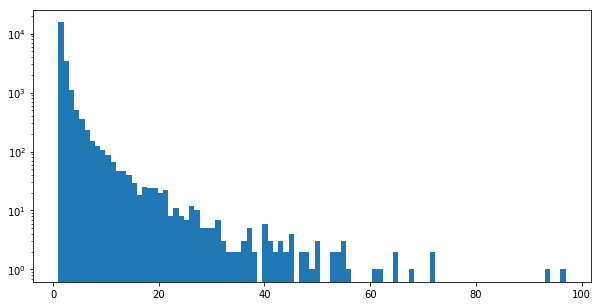

count    22157.000000
mean         2.040574
std          3.634244
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         97.000000
dtype: float64

There are 15529 single-article events and 6628 multiple-article events.


In [13]:
get_infomap_descriptives(H, '../../report/figures/infomapcos02')

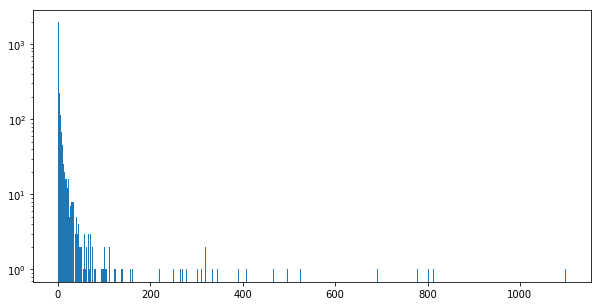

count    3756.000000
mean       12.142705
std        63.962180
min         1.000000
25%         1.000000
50%         1.000000
75%         4.000000
max      1099.000000
dtype: float64

There are 1951 single-article events and 1805 multiple-article events.


In [14]:
get_infomap_descriptives(Hsoft, '../../report/figures/infomapsoft02')

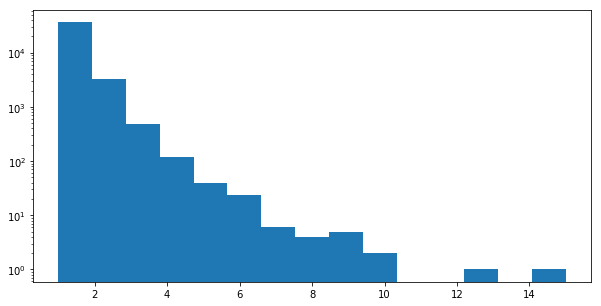

count    40249.000000
mean         1.123332
std          0.447774
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
dtype: float64

There are 36347 single-article events and 3902 multiple-article events.


In [16]:
get_infomap_descriptives(H06, '../../report/figures/infomapcos06')

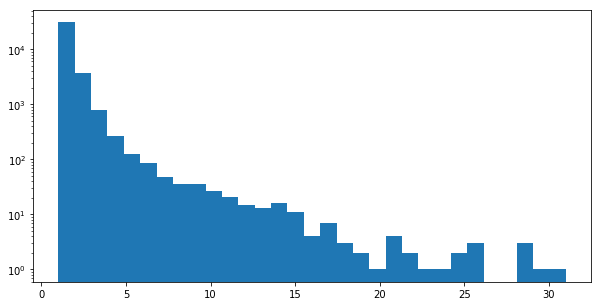

count    35924.000000
mean         1.269569
std          1.114714
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         31.000000
dtype: float64

There are 30698 single-article events and 5226 multiple-article events.


In [15]:
get_infomap_descriptives(Hsoft06, '../../report/figures/infomapsoft06')

We see that infomap performs *when used without a threshold* considerably worse than the Leiden algorithms (provided a good threshold): max is too high, mean as well. Large diff between softcosine and cosine.nue
Makes sense though for the "story chains" of Nicholls et al: it's less strict than an event, and it's fine if the story continues with different event.

** if used with threshold, very similar results to our apporach **

# Scratch for further looking into the results of infomap below

## wat we nog zouden kunnen doen: zelfde evaluatie als bij Leiden

In [ ]:
for e in Gnxcos.edges(data=True):
    print(*e)

In [ ]:
G_recoveredlabels = nx.relabel_nodes(Gint, dict(zip(Gint,G)))

In [ ]:
nx.draw(G, with_labels=True)

In [ ]:
H_labeled = nx.relabel_nodes(H, dict(zip(H,G)))

In [ ]:
nx.draw(H_labeled, with_labels=True)

In [ ]:

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.5]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.show()

In [ ]:
G.edges(data=True)